In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import time

from CNN import *
from DatasetLoaders import RoadSignDataset


# transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # Resize images to 32x32
#     transforms.ToTensor(),  # Convert PIL Image to Tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
# ])

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),  # Convert PIL Image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


dataset = RoadSignDataset(root_dir='images', annotations_dir='annotations', transform=transform)
dataset.showClassStats()

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Initialize the model
model = CNN_32x32_orig().to(device)

Label: stop 0, Count: 856
Label: general-caution 4, Count: 1200
Label: crosswalk 2, Count: 328
Label: trafficlight 3, Count: 61
Label: speedlimit 1, Count: 652


Model: CNN_32x32_orig, Device: cpu, Batch Size: 4
Epoch [1/10], Train Loss: 0.7516, Test Loss: 0.6284, Test Accuracy: 79.19%
Epoch [2/10], Train Loss: 0.5514, Test Loss: 0.4354, Test Accuracy: 87.26%
Epoch [3/10], Train Loss: 0.4239, Test Loss: 0.4273, Test Accuracy: 87.26%
Epoch [4/10], Train Loss: 0.3952, Test Loss: 0.3716, Test Accuracy: 88.39%
Epoch [5/10], Train Loss: 0.3497, Test Loss: 0.3959, Test Accuracy: 89.03%
Epoch [6/10], Train Loss: 0.3180, Test Loss: 0.2695, Test Accuracy: 92.58%
Epoch [7/10], Train Loss: 0.2850, Test Loss: 0.2710, Test Accuracy: 91.45%
Epoch [8/10], Train Loss: 0.2591, Test Loss: 0.2522, Test Accuracy: 91.77%
Epoch [9/10], Train Loss: 0.2619, Test Loss: 0.2407, Test Accuracy: 92.58%
Epoch [10/10], Train Loss: 0.2495, Test Loss: 0.2328, Test Accuracy: 92.90%
Training finished in 304.0 seconds


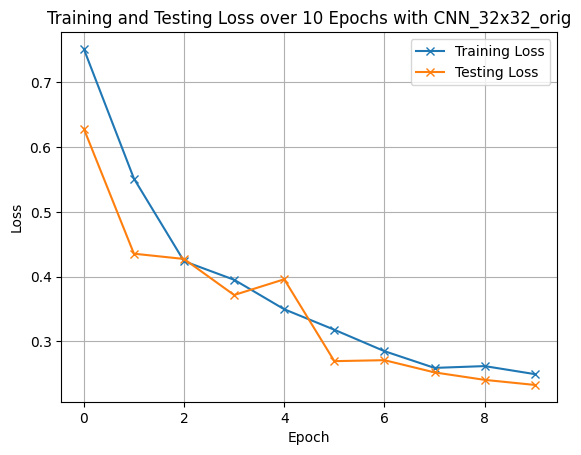

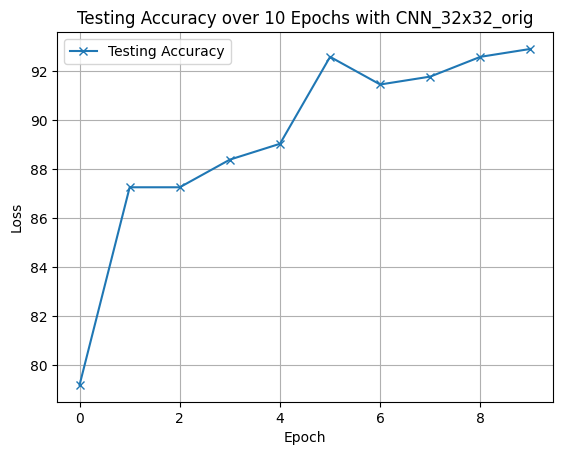

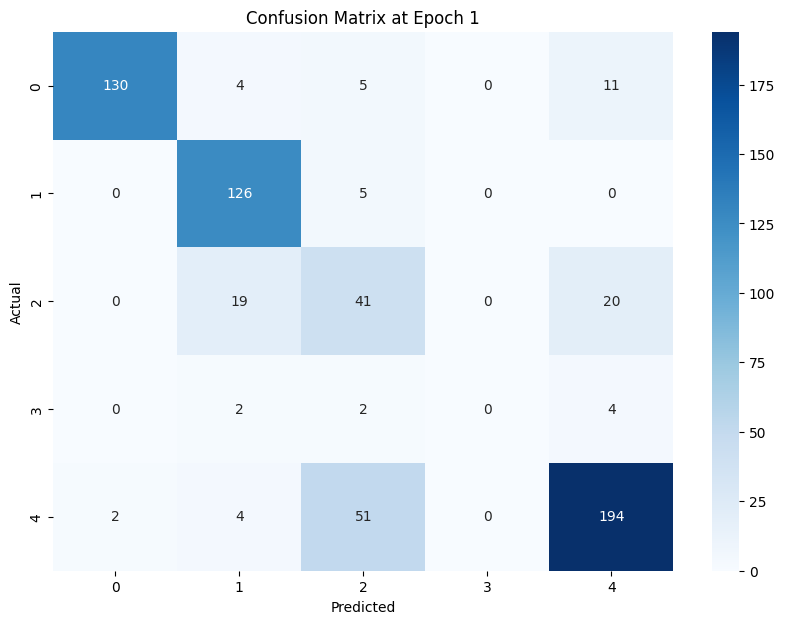

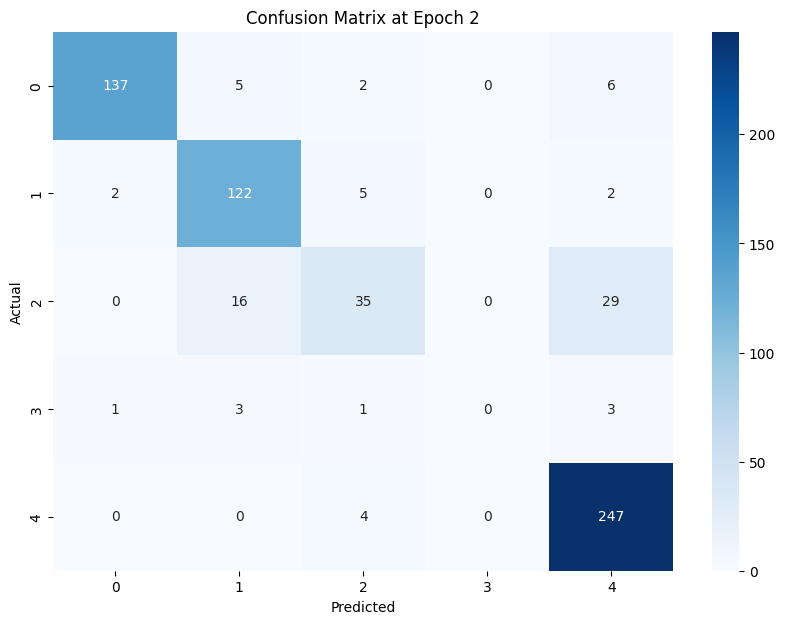

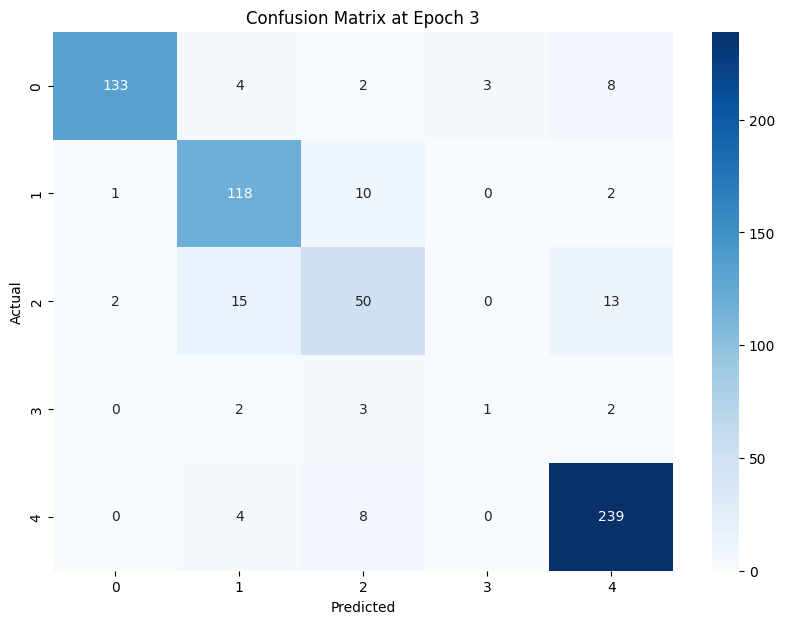

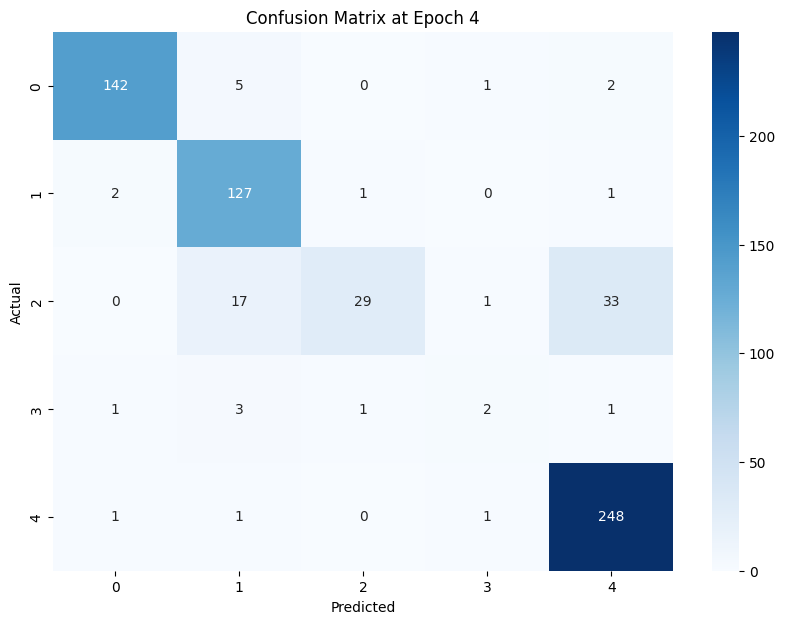

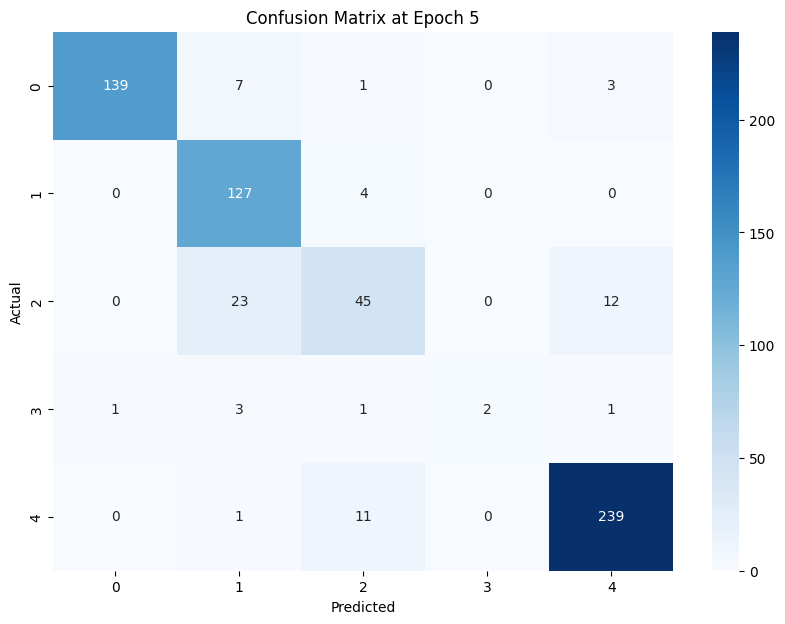

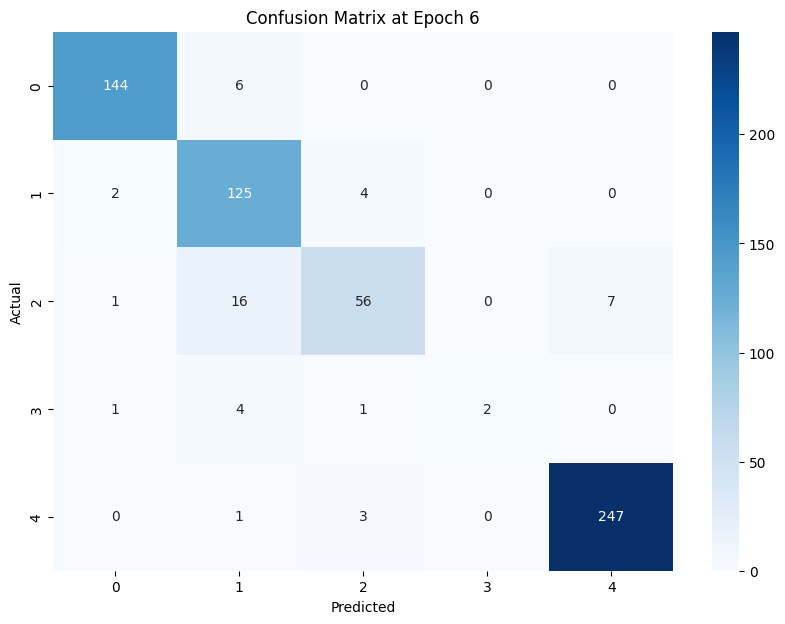

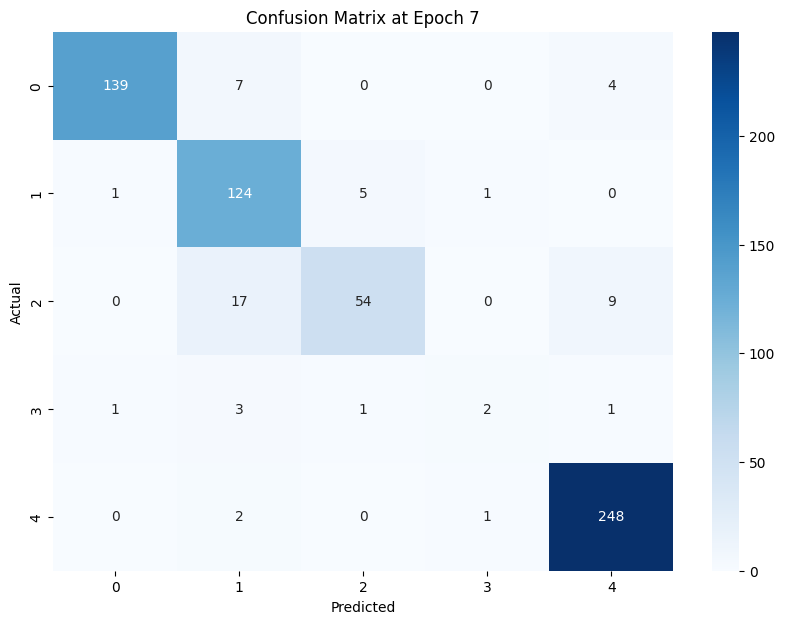

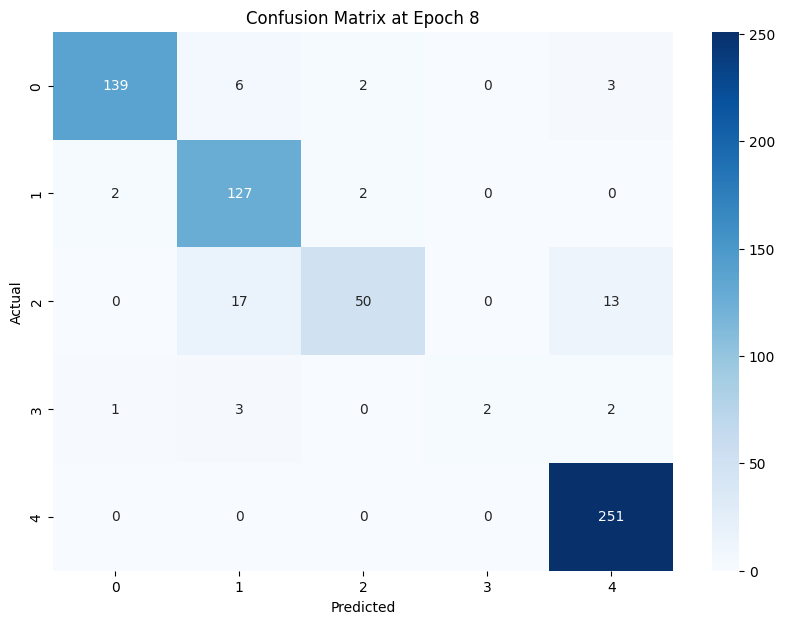

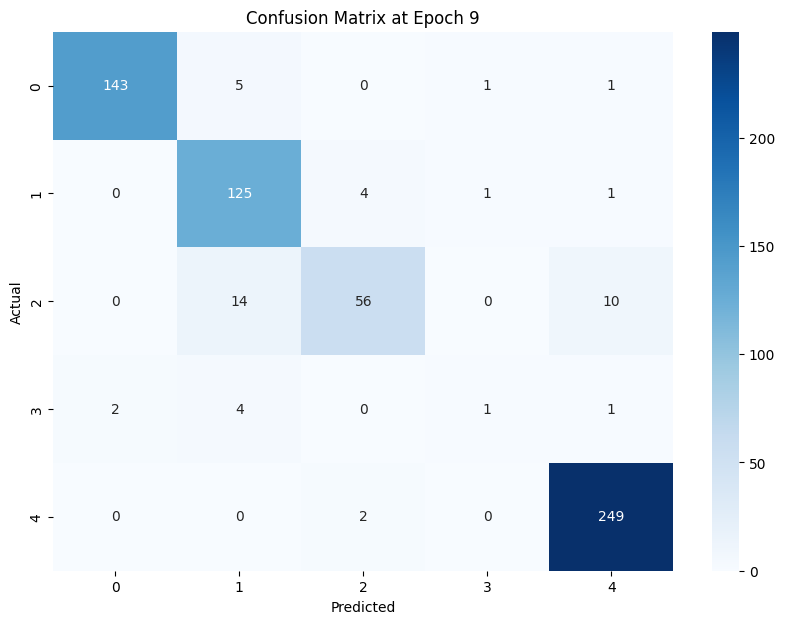

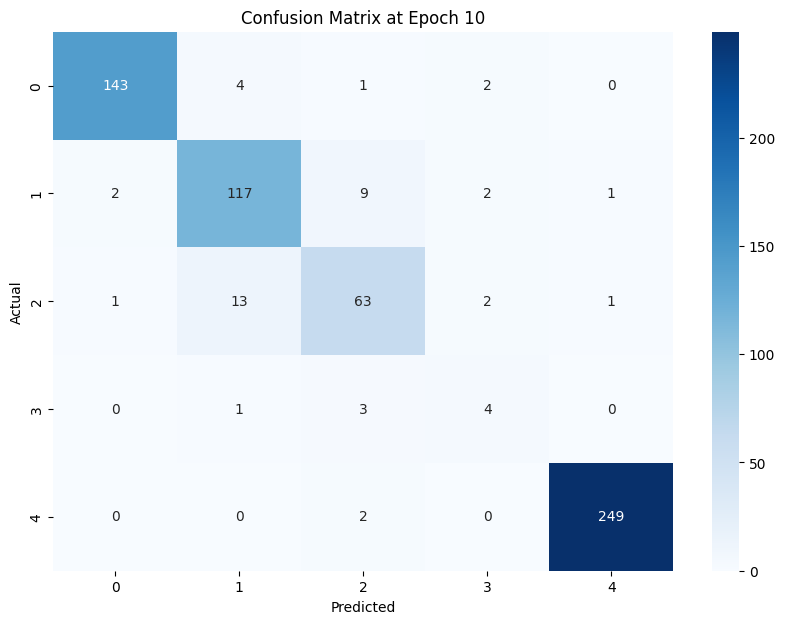

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
print(f"Model: {model.name}, Device: {device}, Batch Size: {batch_size}")
time_start = time.time()
num_epochs = 10
total_step = len(train_loader)
train_loss_data = np.zeros(num_epochs)
test_loss_data = np.zeros(num_epochs)
test_accuracy_data = np.zeros(num_epochs)
confusion_matrices = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss_data[epoch] = train_loss / len(train_loader)

    # Testing loop
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss_data[epoch] = test_loss / len(test_loader)
    test_accuracy_data[epoch] = 100 * correct / total

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    confusion_matrices.append(cm)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss_data[epoch]:.4f}, '
          f'Test Loss: {test_loss_data[epoch]:.4f}, '
          f'Test Accuracy: {test_accuracy_data[epoch]:.2f}%')
    
dt = time.time() - time_start
print(f'Training finished in {dt:.1f} seconds')

# Plotting the losses
plt.figure()
plt.plot(np.arange(num_epochs), train_loss_data, '-x', label='Training Loss')
plt.plot(np.arange(num_epochs), test_loss_data, '-x', label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Testing Loss over {num_epochs} Epochs with {model.name}')
plt.legend()
plt.grid()
# plt.show()

# Plotting Testing Accuracy
plt.figure()
plt.plot(np.arange(num_epochs), test_accuracy_data, '-x', label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Testing Accuracy over {num_epochs} Epochs with {model.name}')
plt.legend()
plt.grid()
plt.show()


# Plot confusion matricies for each epcoch:
for epoch, cm in enumerate(confusion_matrices, 1):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix at Epoch {epoch}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


results of some tests:

**Model 1: LR 0.1, Cross Entropy Loss, SGD**

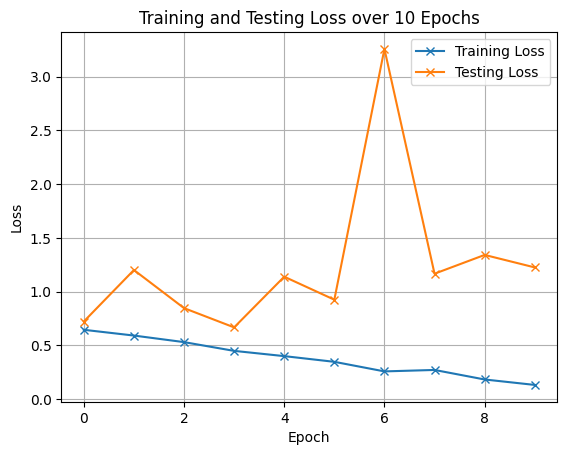


**Model 2: LR 0.05, Cross Entropy Loss, ASGD**

Epoch [1/10], Train Loss: 1.5715, Test Loss: 1.2289, Test Accuracy: 46.59%
Epoch [2/10], Train Loss: 0.7532, Test Loss: 0.6656, Test Accuracy: 77.84%
Epoch [3/10], Train Loss: 0.7007, Test Loss: 0.5906, Test Accuracy: 78.98%
Epoch [4/10], Train Loss: 0.6760, Test Loss: 0.6046, Test Accuracy: 82.95%
Epoch [5/10], Train Loss: 0.6071, Test Loss: 0.5874, Test Accuracy: 82.95%
Epoch [6/10], Train Loss: 0.5951, Test Loss: 0.6998, Test Accuracy: 79.55%
Epoch [7/10], Train Loss: 0.5590, Test Loss: 0.6152, Test Accuracy: 82.39%
Epoch [8/10], Train Loss: 0.5485, Test Loss: 1.2222, Test Accuracy: 51.70%
Epoch [9/10], Train Loss: 0.5153, Test Loss: 0.9548, Test Accuracy: 67.61%
Epoch [10/10], Train Loss: 0.4167, Test Loss: 0.7151, Test Accuracy: 79.55%

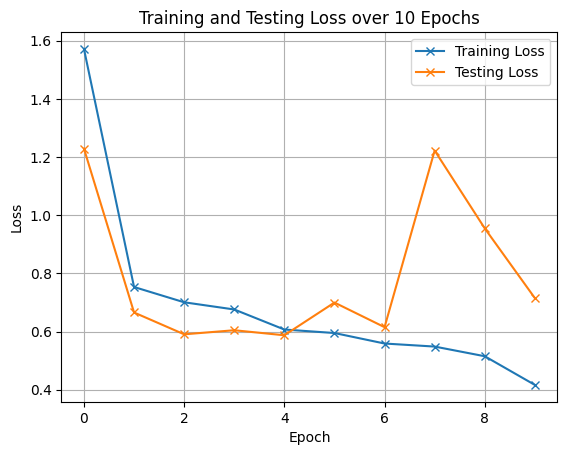